In [1]:
import DecisionMesh
import numpy as np
import pandas as pd

In [2]:
def test_active_face(face: DecisionMesh.Face):
    print('Has 3 edges:', face.edges[0] is not None and face.edges[1] is not None and face.edges[2] is not None)
    print('Has 3 vertices:', face.vertices[0] is not None and face.vertices[1] is not None and face.vertices[2] is not None)
    print('Opposite Vertices not in corresponding edge:', face.edges[0].other_vertex(face.vertices[0]) is None and face.edges[1].other_vertex(face.vertices[1]) is None and face.edges[2].other_vertex(face.vertices[2]) is None)
    print('Is active:', face.active)
    print('each edge contains this face:', face in face.edges[0].faces.values() and face in face.edges[1].faces.values() and face in face.edges[2].faces.values())
    
def test_edge_endpoints(face: DecisionMesh.Face) -> bool:
    """
    Verify that for each edge i of the face:
      - the edge contains the two non-opposite vertices (v_{i+1}, v_{i+2})
      - it does not contain the opposite vertex v_i
      - endpoints are distinct
      - other_vertex round-trips on both endpoints
    Prints ONLY on errors. Returns True if all checks pass.
    """
    all_ok = True
    for i, e in enumerate(face.edges):
        v_opp = face.vertices[i]
        v_a   = face.vertices[(i+1) % 3]
        v_b   = face.vertices[(i+2) % 3]

        errors = []

        # membership via other_vertex (your criterion)
        has_a   = e.other_vertex(v_a) is not None
        has_b   = e.other_vertex(v_b) is not None
        has_opp = e.other_vertex(v_opp) is not None

        if not has_a:
            errors.append("missing non-opposite vertex v_(i+1)")
        if not has_b:
            errors.append("missing non-opposite vertex v_(i+2)")
        if has_opp:
            errors.append("contains opposite vertex v_i")

        # endpoints must be exactly {v_a, v_b}
        if {e.vertex0, e.vertex1} != {v_a, v_b}:
            errors.append("endpoints not exactly the two non-opposite vertices")

        # endpoints must be distinct
        if e.vertex0 is e.vertex1:
            errors.append("edge endpoints are identical")

        # round-trip consistency for endpoints
        if has_a and (e.other_vertex(e.other_vertex(v_a)) is not v_a):
            errors.append("round-trip failed for v_(i+1)")
        if has_b and (e.other_vertex(e.other_vertex(v_b)) is not v_b):
            errors.append("round-trip failed for v_(i+2)")

        if errors:
            all_ok = False
            print(f"Edge {i}: " + "; ".join(errors))

    return all_ok

def test_face_subdivisions(face: DecisionMesh.Face, eps: float = 1e-12) -> bool:
    """
    Verify each subdivision i of `face`:
      - sub['e'], sub['+'], sub['-'] exist
      - sub['e'] is (midpoint of edge i) -> (vertex i)
      - '+' & '-' faces each contain {midpoint, vertex_i}
      - '+' has exactly one endpoint of edge i with s>0; '-' the other with s<0
      - sub['e'] belongs to BOTH child faces
      - area(+) + area(-) ~= area(parent)
      - Activity:
          * in each child face, the edge opposite the midpoint is ACTIVE
          * the other two edges (spoke + sub-edge) are INACTIVE
          * the child faces themselves are INACTIVE
    Prints ONLY on errors. Returns True if all checks pass.
    """
    def is_edge_active(e):
        # Prefer explicit flag if present; else infer by presence of sub_edges (set when activated)
        if hasattr(e, 'active'):
            return bool(e.active)
        return hasattr(e, 'sub_edges')

    all_ok = True

    for i in range(3):
        sub = face.sub_divisions[i]
        parent_edge = face.edges[i]
        v_i = face.vertices[i]
        v_a = face.vertices[(i+1) % 3]
        v_b = face.vertices[(i+2) % 3]
        mid = getattr(parent_edge, 'midpoint', None)

        # 1) existence
        e = sub.get('e', None)
        f_plus = sub.get('+', None)
        f_minus = sub.get('-', None)
        if any(x is None for x in (e, f_plus, f_minus, mid)):
            all_ok = False
            missing = [name for name, x in [('e', e), ('+', f_plus), ('-', f_minus), ('midpoint', mid)] if x is None]
            print(f"Subdiv {i}: missing {', '.join(missing)}")
            continue

        # 2) spoke orientation: midpoint -> vertex_i
        if not (e.vertex0 is mid and e.vertex1 is v_i):
            all_ok = False
            print(f"Subdiv {i}: sub edge 'e' endpoints wrong (expected vertex0=midpoint, vertex1=vertex_i).")

        # 3) both children must contain {mid, v_i}
        if not ({mid, v_i} <= set(f_plus.vertices)):
            all_ok = False
            print(f"Subdiv {i}: '+' face missing midpoint or vertex_i.")
        if not ({mid, v_i} <= set(f_minus.vertices)):
            all_ok = False
            print(f"Subdiv {i}: '-' face missing midpoint or vertex_i.")

        # 4) each child has exactly one endpoint of parent edge; together cover both
        endpoints = {parent_edge.vertex0, parent_edge.vertex1}
        plus_ep  = endpoints & set(f_plus.vertices)
        minus_ep = endpoints & set(f_minus.vertices)
        if not (len(plus_ep) == 1 and len(minus_ep) == 1 and plus_ep.isdisjoint(minus_ep)):
            all_ok = False
            print(f"Subdiv {i}: endpoint distribution incorrect "
                  f"(plus has {len(plus_ep)}, minus has {len(minus_ep)}; must be 1 & 1, disjoint).")

        # 5) '+' / '-' classification using the SPOKE edge e (midpoint -> vertex_i).
        #    We check the child's unique third vertex (the endpoint of the parent edge it kept),
        #    and also the child's centroid. Both must be strictly on the expected side:
        #      '+' child:  e.test_vertex(...) > +eps
        #      '-' child:  e.test_vertex(...) < -eps

        def centroid_vertex(f: 'DecisionMesh.Face') -> 'DecisionMesh.Vertex':
            return DecisionMesh.Vertex(f.mesh,
                        sum(v.x for v in f.vertices) / 3.0,
                        sum(v.y for v in f.vertices) / 3.0, real_vertex = False)

        # unique "third" vertex in each child (the one not lying on the spoke edge e)
        third_plus  = next((v for v in f_plus.vertices  if v is not e.vertex0 and v is not e.vertex1),  None)
        third_minus = next((v for v in f_minus.vertices if v is not e.vertex0 and v is not e.vertex1), None)
        if third_plus is None or third_minus is None:
            all_ok = False
            print(f"Subdiv {i}: could not identify third vertex in one of the children.")
        else:
            s_plus_v  = float(e.test_vertex(third_plus))
            s_minus_v = float(e.test_vertex(third_minus))
            if not (s_plus_v > eps and s_minus_v < -eps):
                all_ok = False
                print(f"Subdiv {i}: wrong side by spoke-edge at child 'third' vertices "
                    f"(s_plus={s_plus_v:.3g}, s_minus={s_minus_v:.3g}).")

            # centroid strict check (avoid boundary cases at endpoints)
            c_plus  = centroid_vertex(f_plus)
            c_minus = centroid_vertex(f_minus)
            s_plus_c  = float(e.test_vertex(c_plus))
            s_minus_c = float(e.test_vertex(c_minus))
            if not (s_plus_c > eps and s_minus_c < -eps):
                all_ok = False
                print(f"Subdiv {i}: wrong side by spoke-edge at child centroids "
                    f"(s_plus_c={s_plus_c:.3g}, s_minus_c={s_minus_c:.3g}).")


        # 6) 'e' must be in both child faces' edge lists
        if e not in f_plus.edges:
            all_ok = False
            print(f"Subdiv {i}: '+' face does not include sub edge 'e'.")
        if e not in f_minus.edges:
            all_ok = False
            print(f"Subdiv {i}: '-' face does not include sub edge 'e'.")

        # 7) area consistency
        ap = face.area
        ac = f_plus.area + f_minus.area
        if not (abs(ac - ap) <= max(eps, 1e-10 * max(1.0, ap))):
            all_ok = False
            print(f"Subdiv {i}: area mismatch; parent={ap:.12g}, children_sum={ac:.12g}.")

        # 8) Activity checks inside child faces
        for tag, f_child in (('+', f_plus), ('-', f_minus)):
            # Identify the unique edge in f_child that does NOT touch the midpoint: that's the edge opposite the midpoint
            edges_not_touching_mid = [ed for ed in f_child.edges if mid not in (ed.vertex0, ed.vertex1)]
            if len(edges_not_touching_mid) != 1:
                all_ok = False
                print(f"Subdiv {i}{tag}: expected exactly one edge opposite midpoint, found {len(edges_not_touching_mid)}.")
                continue

            opposite_mid = edges_not_touching_mid[0]
            # Opposite-midpoint edge should be ACTIVE
            if not is_edge_active(opposite_mid):
                all_ok = False
                print(f"Subdiv {i}{tag}: edge opposite midpoint should be ACTIVE but is not.")

            # The other two edges (spoke 'e' and the sub-edge on the parent edge) should be INACTIVE
            for ed in f_child.edges:
                if ed is opposite_mid:
                    continue
                if is_edge_active(ed):
                    all_ok = False
                    print(f"Subdiv {i}{tag}: non-opposite edge is ACTIVE but should be INACTIVE.")

            # Child faces themselves should be INACTIVE
            active_flag = getattr(f_child, 'active', None)
            if active_flag is not False:
                all_ok = False
                state = 'missing' if active_flag is None else active_flag
                print(f"Subdiv {i}{tag}: child face should be inactive (False), got {state}.")

    return all_ok

def check_invariants(mesh):
    problems = []

    # 1) Every active face should have all its edges active and registered with that face
    for f in list(mesh.active_faces):
        for e in f.edges:
            if not e.active:
                problems.append(("face_edge_inactive", f, e))
            # edge must point back to this face (+/-)
            if f is not e.faces.get('+') and f is not e.faces.get('-'):
                problems.append(("face_not_registered_on_edge", f, e))

    # 2) Every active edge must be present on both endpoint vertices
    for e in list(mesh.active_edges):
        if e not in e.vertex0.edges:
            problems.append(("edge_missing_from_vertex0", e, e.vertex0))
        if e not in e.vertex1.edges:
            problems.append(("edge_missing_from_vertex1", e, e.vertex1))

    # 3) Every vertex used by active faces should be connected to at least two edges
    used_vertices = set()
    for f in list(mesh.active_faces):
        used_vertices.update(f.vertices)
    for v in used_vertices:
        if len(v.edges) == 0:
            problems.append(("vertex_used_but_isolated", v, None))

    # 4) Edge faces slots must be active or None
    for e in list(mesh.active_edges):
        for side in ('+', '-'):
            f = e.faces.get(side)
            if f is not None and f not in mesh.active_faces:
                problems.append(("edge_points_to_inactive_face", e, f))

    # 5) Triangles should be buildable: all face vertices must be in _all_vertices
    verts = set(mesh._all_vertices())
    for f in list(mesh.active_faces):
        for v in f.vertices:
            if v not in verts:
                problems.append(("face_vertex_not_in_all_vertices", f, v))

    if problems:
        print("Invariant problems:")
        for tag, a, b in problems[:50]:
            print(" -", tag, a, b)
    else:
        print("All invariants OK.")

    return problems


Has 3 edges: True
Has 3 vertices: True
Opposite Vertices not in corresponding edge: True
Is active: True
each edge contains this face: True
True
True


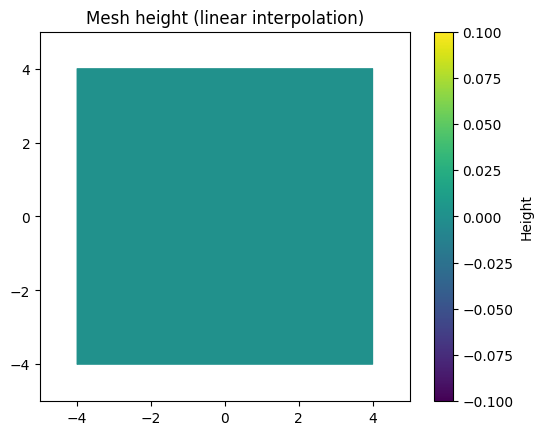

In [3]:
# generate 100 samples of 2D standard normals
np.random.seed(0)

rng = np.random.default_rng(42)  # reproducible

n = 10000
x0 = rng.uniform(-4, 4, size=n)
x1 = rng.uniform(-4, 4, size=n)
x2 = rng.standard_normal(n) + 2 * np.cos(5 * x0) * np.cos(2 * x1)

df = pd.DataFrame({
    0: x0,
    1: x1,
    2: x2
})



mesh = DecisionMesh.DecisionMesh(df)

face = mesh.top_face
test_active_face(face)
print(test_edge_endpoints(face))
print(test_face_subdivisions(face))
mesh.plot_height()



999

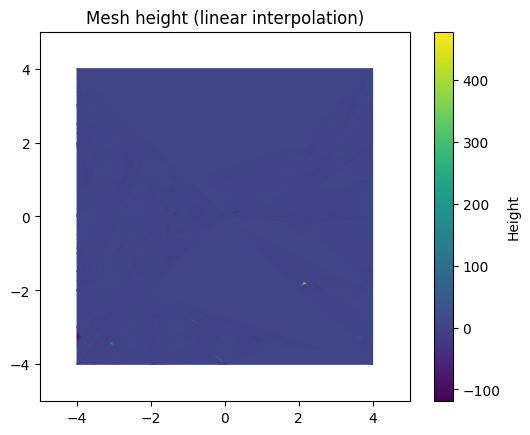

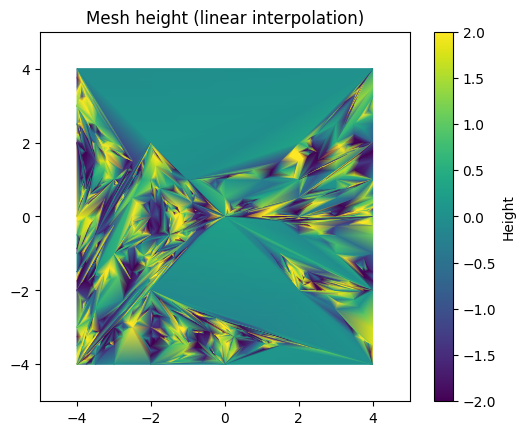

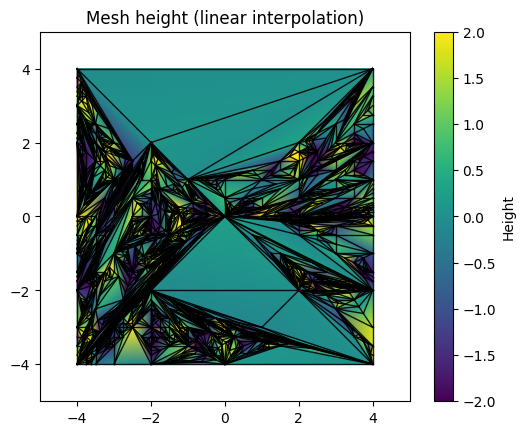

In [ ]:
for i in range(1000):
    print(f'\r{i}', end='', flush=True)
    mesh.update_best_vertex(random = 0.1)

mesh.plot_height()
mesh.plot_height(vmax_abs = 2)
mesh.plot_height(vmax_abs = 2, draw_edges = True)


In [5]:
for face in mesh.active_faces:
    print(face.aspect_ratio())

3.252369039855693
3.162535257869295
2.2363108396443767
4.816710007962923
2.000255586098347
4.49480841403151
2.372132615491418
3.578097427857548
3.3501061772405807
2.236105338721547
4.472210677443092
2.236310839644384
3.1625352578692976
4.233603458288991
2.8288112225926865
2.236553807326432
2.893158446156501
3.234467910483545
1.8029262972364122
2.0615001136300752
2.235946569503752
2.8055841995703767
2.5296160667596346
2.5496428881696995
4.123039784149014
1.8025496862407926
2.6923302705298475
2.235946569503735
2.665314611138814
1.4144056112963483
4.817925852072677
2.6924815805638462
3.162191812916409
2.2361053387215466
2.4807672262993345
4.1230397841490385
3.2344679104835423
3.549084768861116
4.1224571862557795
3.3735000373398916
3.0089589413976023
4.007947731682233
2.1660073725262685
2.549642888169702
3.1376943167687674
1.9631745474076954
2.922318278359433
2.987289657802472
3.6055060950756457
2.295830391855819
2.607635151088741
3.2732297140928885
2.8857814638522545
3.821074215055467
2.4